In [1]:
import os
import shutil
from PIL import Image

def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
    print(f"Folder {folder_path} cleared.")

# Define a local working directory inside Colab
working_dir = '/content/invalid_files'
clear_folder(working_dir)

def verify_and_copy_images(source, destination):
    os.makedirs(destination, exist_ok=True)
    for root, _, files in os.walk(source):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                shutil.copy(file_path, destination)
                print(f"Copied non-image file: {file_path}")

# Use your actual dataset path on Google Drive
train_folder = '/content/drive/MyDrive/weed-detection/train'
verify_and_copy_images(train_folder, working_dir)


Folder /content/invalid_files cleared.
Copied non-image file: /content/drive/MyDrive/weed-detection/train/_annotations.coco.json


In [2]:
import os
import json
import shutil
from tqdm import tqdm

def convert_coco_to_yolo(coco_file, source_images_dir, output_dir):
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(f"{output_dir}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/labels", exist_ok=True)

    categories = coco_data.get("categories", [])
    category_mapping = {cat["id"]: idx for idx, cat in enumerate(categories)}

    for annotation in tqdm(coco_data["annotations"], desc="Converting annotations"):
        try:
            image_id = annotation["image_id"]
            bbox = annotation["bbox"]
            category_id = annotation["category_id"]
            image_info = next(img for img in coco_data["images"] if img["id"] == image_id)
            img_filename = image_info["file_name"]
            img_width = image_info["width"]
            img_height = image_info["height"]

            x_min, y_min, width, height = bbox
            x_center = (x_min + width / 2) / img_width
            y_center = (y_min + height / 2) / img_height
            norm_width = width / img_width
            norm_height = height / img_height

            class_id = category_mapping[category_id]
            yolo_line = f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n"

            txt_filename = os.path.splitext(img_filename)[0] + ".txt"
            with open(os.path.join(output_dir, "labels", txt_filename), "a") as f:
                f.write(yolo_line)

            shutil.copy(os.path.join(source_images_dir, img_filename), os.path.join(output_dir, "images", img_filename))
        except Exception as e:
            print(f"Error processing annotation {annotation}: {e}")

# Updated paths for Google Colab
convert_coco_to_yolo(
    coco_file="/content/drive/MyDrive/weed-detection/train/_annotations.coco.json",
    source_images_dir="/content/drive/MyDrive/weed-detection/train",
    output_dir="/content/yolo_format/train"
)

convert_coco_to_yolo(
    coco_file="/content/drive/MyDrive/weed-detection/test/_annotations.coco.json",
    source_images_dir="/content/drive/MyDrive/weed-detection/test",
    output_dir="/content/yolo_format/test"
)


Converting annotations: 100%|██████████| 662/662 [01:47<00:00,  6.18it/s]


In [3]:
from sklearn.model_selection import train_test_split
import os
import shutil

def split_dataset(output_dir, train_ratio=0.8):

    train_images_dir = f"{output_dir}/train/images"
    train_labels_dir = f"{output_dir}/train/labels"
    test_images_dir = f"{output_dir}/test/images"  # (not used here but keeping for completeness)
    test_labels_dir = f"{output_dir}/test/labels"

    train_image_files = os.listdir(train_images_dir)
    train_label_files = [f for f in os.listdir(train_labels_dir) if f.endswith(".txt")]

    train_images, val_images = train_test_split(train_image_files, test_size=1-train_ratio, random_state=42)

    # Output structure adapted for Google Colab
    final_train_images_dir = '/content/dataset/images/train'
    final_val_images_dir = '/content/dataset/images/val'
    final_train_labels_dir = '/content/dataset/labels/train'
    final_val_labels_dir = '/content/dataset/labels/val'

    os.makedirs(final_train_images_dir, exist_ok=True)
    os.makedirs(final_val_images_dir, exist_ok=True)
    os.makedirs(final_train_labels_dir, exist_ok=True)
    os.makedirs(final_val_labels_dir, exist_ok=True)

    for image_file in train_images:
        shutil.copy(os.path.join(train_images_dir, image_file), os.path.join(final_train_images_dir, image_file))
        label_file = os.path.splitext(image_file)[0] + ".txt"
        if label_file in train_label_files:
            shutil.copy(os.path.join(train_labels_dir, label_file), os.path.join(final_train_labels_dir, label_file))

    for image_file in val_images:
        shutil.copy(os.path.join(train_images_dir, image_file), os.path.join(final_val_images_dir, image_file))
        label_file = os.path.splitext(image_file)[0] + ".txt"
        if label_file in train_label_files:
            shutil.copy(os.path.join(train_labels_dir, label_file), os.path.join(final_val_labels_dir, label_file))

    print(f"✅ Dataset prepared with {len(train_images)} training and {len(val_images)} validation images.")

# Updated input directory for Colab
split_dataset("/content/yolo_format")

✅ Dataset prepared with 1324 training and 331 validation images.


In [5]:
yaml_path = '/content/dataset.yaml'

with open(yaml_path, 'w') as f:
    f.write("""
path: /content/dataset
train: images/train
val: images/val
nc: 2
names: ['class1', 'class2']
""")


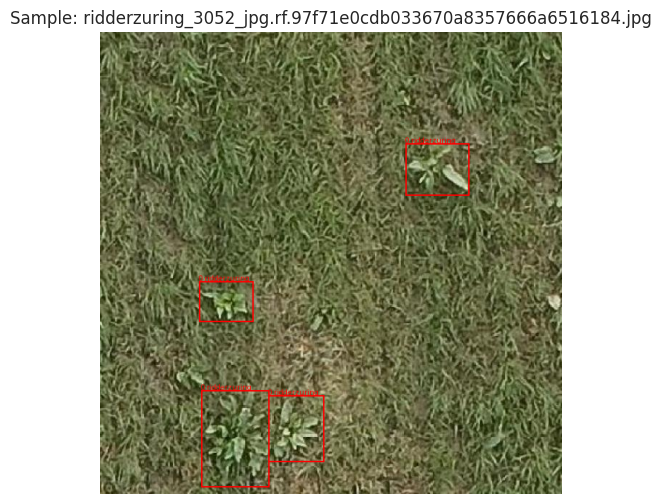

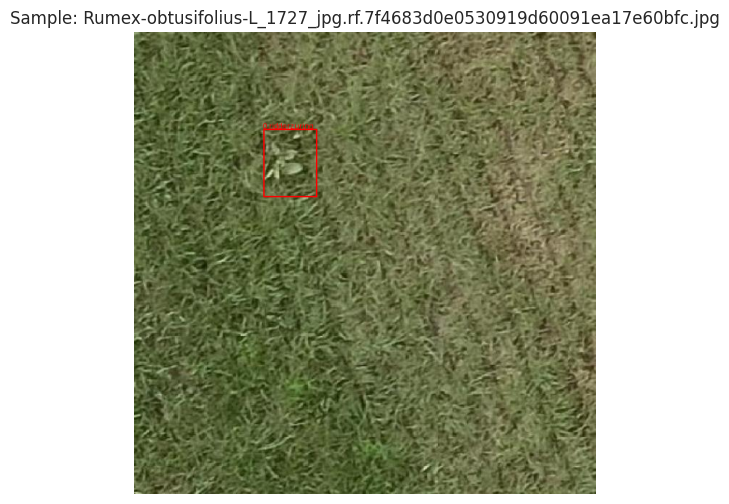

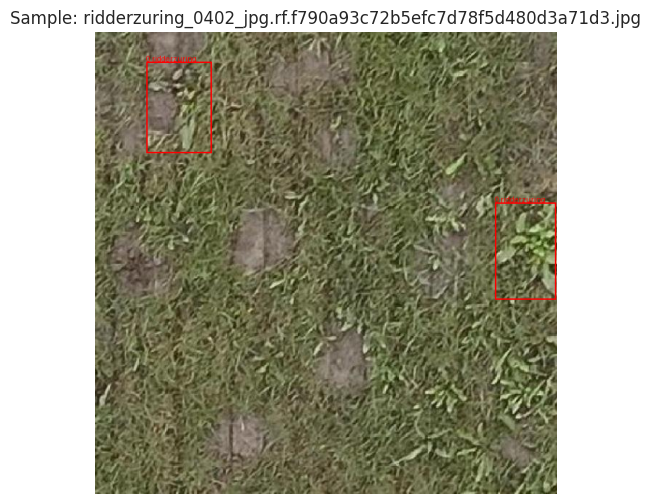

In [25]:
import json
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageDraw
import random

# Load annotations
coco_path = '/content/drive/MyDrive/weed-detection/train/_annotations.coco.json'
image_dir = '/content/drive/MyDrive/weed-detection/train'

with open(coco_path, 'r') as f:
    coco = json.load(f)

# Map category IDs to names
category_map = {cat["id"]: cat["name"] for cat in coco["categories"]}
def draw_sample_annotations(coco_data, image_dir, num_samples=3):
    images = random.sample(coco_data["images"], num_samples)
    ann_by_img = {}
    for ann in coco_data["annotations"]:
        ann_by_img.setdefault(ann["image_id"], []).append(ann)

    for img_info in images:
        img_path = os.path.join(image_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        for ann in ann_by_img.get(img_info["id"], []):
            bbox = ann["bbox"]
            x, y, w, h = bbox
            class_name = category_map[ann["category_id"]]
            draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
            draw.text((x, y - 10), class_name, fill="red")

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Sample: {img_info['file_name']}")
        plt.axis('off')
        plt.show()

draw_sample_annotations(coco, image_dir)

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [7]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8s.pt')  # You can change this to 'yolov8n.pt', 'yolov8m.pt', etc.

# Train on your custom dataset
model.train(
    data='/content/dataset.yaml',  # Your dataset YAML file
    epochs=30,
    imgsz=640,
    batch=16,
    name='yolov8_custom'
)

# Save the best model to Google Drive (optional)
best_model_path = '/content/runs/detect/yolov8_custom/weights/best.pt'
drive_save_path = '/content/drive/MyDrive/weed-detection/yolov8_best.pt'

# Copy best model to your Google Drive
import shutil
shutil.copy(best_model_path, drive_save_path)

print(f"✅ Model saved to: {drive_save_path}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 244MB/s]


Ultralytics 8.3.108 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 1324 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1324/1324 [00:03<00:00, 381.93it/s]


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<00:00, 336.57it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/yolov8_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_custom
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       3.8G      1.925      2.123      1.656         42        640: 100%|██████████| 83/83 [00:30<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


                   all        331        819      0.775      0.675      0.753      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.58G      1.812      1.305      1.576         52        640: 100%|██████████| 83/83 [00:26<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

                   all        331        819      0.661      0.643      0.655      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.58G      1.838      1.316       1.58         46        640: 100%|██████████| 83/83 [00:25<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        331        819      0.678      0.675      0.669      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.58G      1.804       1.28      1.571         40        640: 100%|██████████| 83/83 [00:26<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

                   all        331        819      0.756      0.723      0.762      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.58G      1.782      1.249      1.561         56        640: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

                   all        331        819      0.789      0.673      0.752       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.58G      1.763      1.216      1.546         36        640: 100%|██████████| 83/83 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

                   all        331        819       0.69      0.686      0.696      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.58G      1.757      1.194      1.532         59        640: 100%|██████████| 83/83 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]

                   all        331        819      0.761      0.735      0.791      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.58G      1.718      1.174       1.52         37        640: 100%|██████████| 83/83 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        331        819      0.759      0.742      0.772      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.58G      1.702      1.171      1.493         50        640: 100%|██████████| 83/83 [00:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


                   all        331        819      0.755      0.726      0.783      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.58G      1.692      1.118      1.499         57        640: 100%|██████████| 83/83 [00:25<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]

                   all        331        819      0.778      0.741      0.786      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.58G      1.668      1.102       1.49         39        640: 100%|██████████| 83/83 [00:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

                   all        331        819       0.75      0.735      0.766      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.58G      1.628      1.074      1.456         43        640: 100%|██████████| 83/83 [00:26<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

                   all        331        819      0.798      0.734      0.789      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.58G      1.637      1.093      1.459         38        640: 100%|██████████| 83/83 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        331        819      0.789      0.742      0.792      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.58G      1.653      1.072      1.471         48        640: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

                   all        331        819      0.768      0.758      0.794      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.58G      1.628       1.07      1.453         49        640: 100%|██████████| 83/83 [00:26<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.42it/s]

                   all        331        819       0.76      0.698      0.774       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.58G      1.622      1.033      1.468         50        640: 100%|██████████| 83/83 [00:26<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]

                   all        331        819      0.803       0.74      0.787      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.58G      1.598      1.029      1.441         24        640: 100%|██████████| 83/83 [00:25<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]

                   all        331        819      0.796       0.75      0.795      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.58G      1.609      1.034      1.449         45        640: 100%|██████████| 83/83 [00:25<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        331        819      0.812       0.74      0.798       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.58G      1.571      1.043      1.432         42        640: 100%|██████████| 83/83 [00:26<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]

                   all        331        819      0.804      0.756      0.801      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.58G      1.605      1.013       1.46         41        640: 100%|██████████| 83/83 [00:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        331        819      0.788      0.766      0.804      0.409


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.58G      1.559     0.9698      1.481         30        640: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

                   all        331        819      0.797      0.775      0.803      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.58G      1.554     0.9483      1.475         31        640: 100%|██████████| 83/83 [00:25<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


                   all        331        819      0.792      0.763      0.794      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.58G      1.552     0.9219      1.473         18        640: 100%|██████████| 83/83 [00:25<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]

                   all        331        819      0.784       0.78      0.799      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.58G      1.544     0.9312      1.463         30        640: 100%|██████████| 83/83 [00:24<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]

                   all        331        819      0.792      0.761      0.801      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.58G      1.514     0.9266      1.454         28        640: 100%|██████████| 83/83 [00:25<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]

                   all        331        819      0.793      0.772      0.802       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.58G      1.519     0.9119      1.457         18        640: 100%|██████████| 83/83 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.20it/s]

                   all        331        819      0.789       0.77      0.805      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.58G      1.499     0.9158      1.449         26        640: 100%|██████████| 83/83 [00:25<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        331        819      0.785      0.773      0.806      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.58G      1.477     0.8858      1.438         27        640: 100%|██████████| 83/83 [00:25<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

                   all        331        819      0.771      0.778      0.805      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.58G      1.479     0.8774      1.429         20        640: 100%|██████████| 83/83 [00:25<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]

                   all        331        819      0.784       0.77      0.807      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.58G      1.458     0.8672      1.428         26        640: 100%|██████████| 83/83 [00:25<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

                   all        331        819       0.79      0.759       0.81      0.418



30 epochs completed in 0.253 hours.
Optimizer stripped from runs/detect/yolov8_custom/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_custom/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_custom/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


                   all        331        819      0.782       0.77      0.807      0.422
                class2        331        819      0.782       0.77      0.807      0.422
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8_custom
✅ Model saved to: /content/drive/MyDrive/weed-detection/yolov8_best.pt


In [8]:
from ultralytics import YOLO

# Load the best trained model (after training)
model = YOLO('/content/runs/detect/yolov8_custom/weights/best.pt')

# Evaluate the model
metrics = model.val(data='/content/dataset.yaml')

# Print out performance metrics
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP50: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")

Ultralytics 8.3.108 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]


                   all        331        819      0.781      0.771      0.807       0.42
                class2        331        819      0.781      0.771      0.807       0.42
Speed: 1.5ms preprocess, 9.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val
Precision: 0.7812
Recall: 0.7715
mAP50: 0.8074
mAP50-95: 0.4201


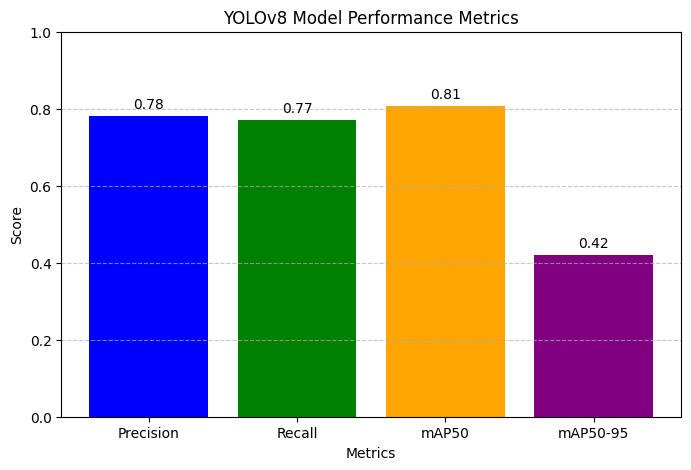

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
map50 = metrics.results_dict['metrics/mAP50(B)']
map5095 = metrics.results_dict['metrics/mAP50-95(B)']

metrics_names = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
metrics_values = [precision, recall, map50, map5095]

plt.figure(figsize=(8, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.title("YOLOv8 Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()


image 1/1 /content/drive/MyDrive/weed-detection/test/ridderzuring_3867_jpg.rf.e44d9fcdb4e011f820dbee64748ef166.jpg: 640x640 1 class2, 18.9ms
Speed: 7.1ms preprocess, 18.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


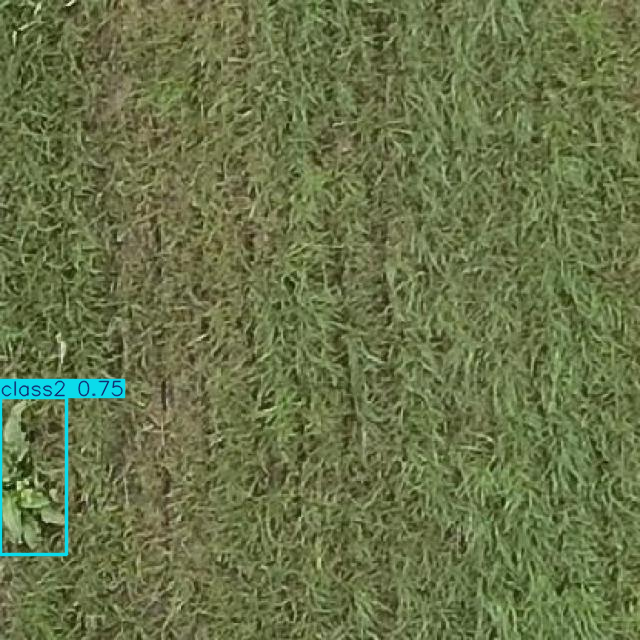

✅ Predicted image saved to: /content/predicted_image.jpg


In [13]:
image_path = '/content/drive/MyDrive/weed-detection/test/ridderzuring_3867_jpg.rf.e44d9fcdb4e011f820dbee64748ef166.jpg'

# Run inference
predictions = model(image_path)

# Show predictions in notebook
predictions[0].show()

# Save the predicted image
output_image_path = '/content/predicted_image.jpg'
predictions[0].save(output_image_path)

print(f"✅ Predicted image saved to: {output_image_path}")


📤 Please upload an image...


Saving ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg to ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg
✅ Uploaded: ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg

image 1/1 /content/ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg: 640x640 8 class2s, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


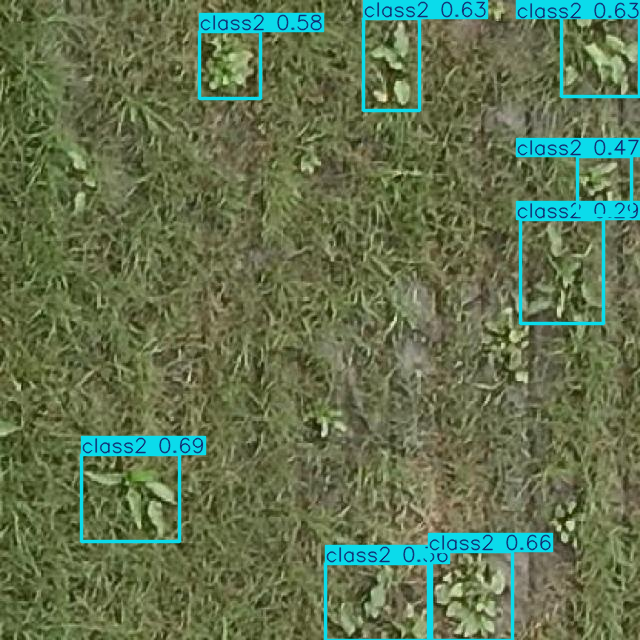

💾 Saved prediction: /content/predicted_ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg
✅ Copied to Drive: /content/drive/MyDrive/weed-detection/predicted_ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg
🔁 Do you want to upload another image? (yes/no): yes
📤 Please upload an image...


❌ No file uploaded. Please try again.
📤 Please upload an image...


❌ No file uploaded. Please try again.
📤 Please upload an image...


❌ No file uploaded. Please try again.
📤 Please upload an image...


Saving ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639.jpg to ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639 (1).jpg
✅ Uploaded: ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639 (1).jpg

image 1/1 /content/ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639 (1).jpg: 640x640 8 class2s, 18.2ms
Speed: 3.6ms preprocess, 18.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


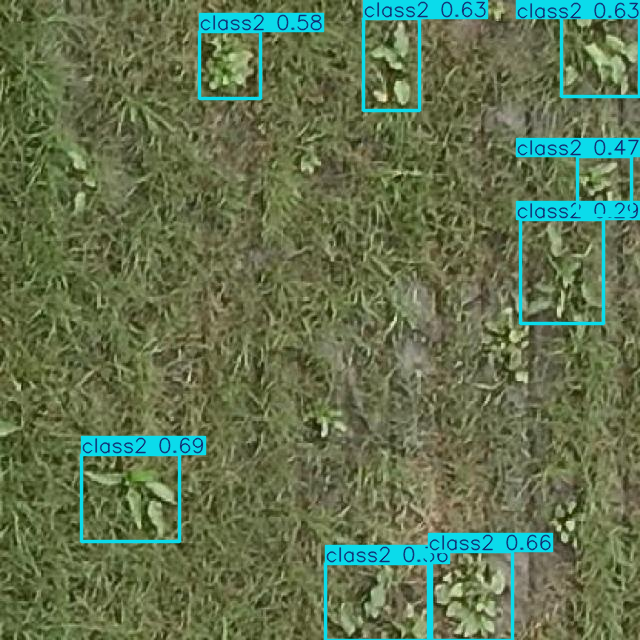

💾 Saved prediction: /content/predicted_ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639 (1).jpg
✅ Copied to Drive: /content/drive/MyDrive/weed-detection/predicted_ridderzuring_3151_jpg.rf.175e23691b2ce606f3054d24896fd639 (1).jpg
🔁 Do you want to upload another image? (yes/no): no
👋 Done with predictions!


In [17]:
from ultralytics import YOLO
from google.colab import files
import shutil

# Load trained YOLOv8 model
model = YOLO('/content/runs/detect/yolov8_custom/weights/best.pt')

while True:
    print("📤 Please upload an image...")
    uploaded = files.upload()

    # Check if any file was uploaded
    if not uploaded:
        print("❌ No file uploaded. Please try again.")
        continue

    # Process the uploaded image
    image_path = list(uploaded.keys())[0]
    print(f"✅ Uploaded: {image_path}")

    # Run prediction
    predictions = model(image_path)
    predictions[0].show()

    # Save locally
    output_image_path = f"/content/predicted_{image_path}"
    predictions[0].save(output_image_path)
    print(f"💾 Saved prediction: {output_image_path}")

    # Save to Google Drive
    drive_path = f"/content/drive/MyDrive/weed-detection/predicted_{image_path}"
    shutil.copy(output_image_path, drive_path)
    print(f"✅ Copied to Drive: {drive_path}")

    # Ask to continue
    again = input("🔁 Do you want to upload another image? (yes/no): ").strip().lower()
    if again != "yes":
        print("👋 Done with predictions!")
        break


In [21]:
import os

# List runs inside YOLO directory
yolo_runs_path = '/content/runs/detect'
if os.path.exists(yolo_runs_path):
    print("Available run folders:")
    print(os.listdir(yolo_runs_path))
else:
    print("❌ No detect folder found at /content/runs/")


Available run folders:
['yolov8_custom', 'val']


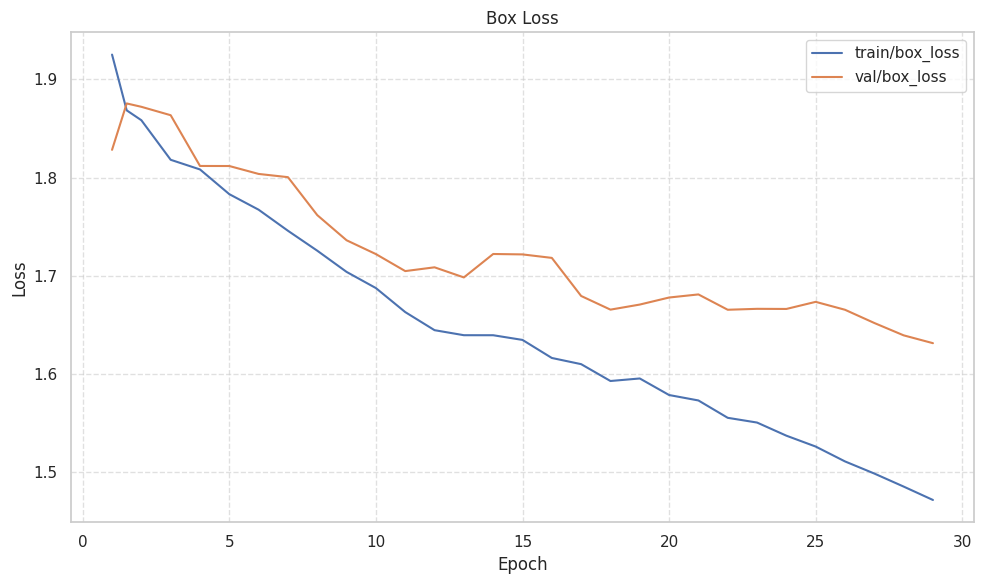

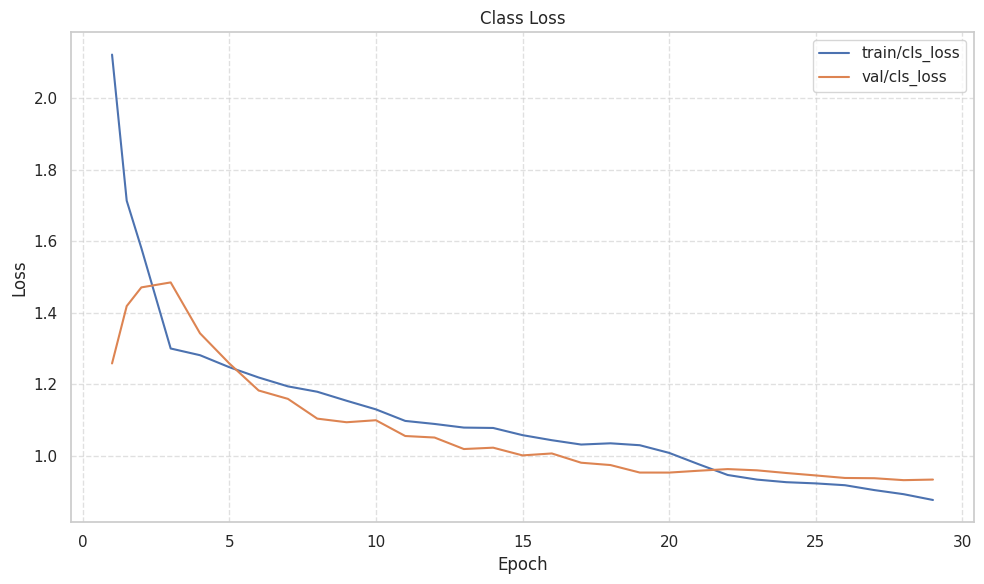

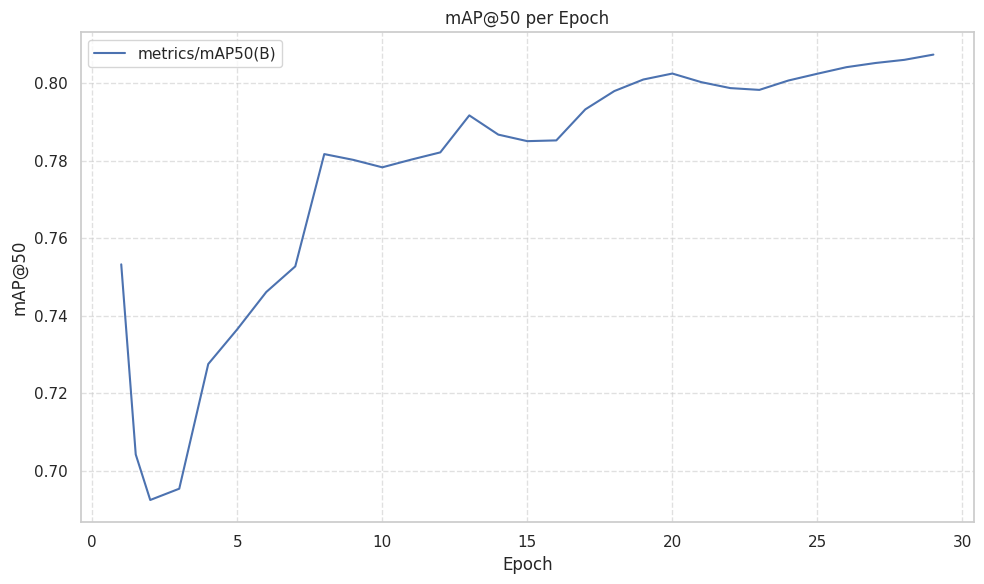

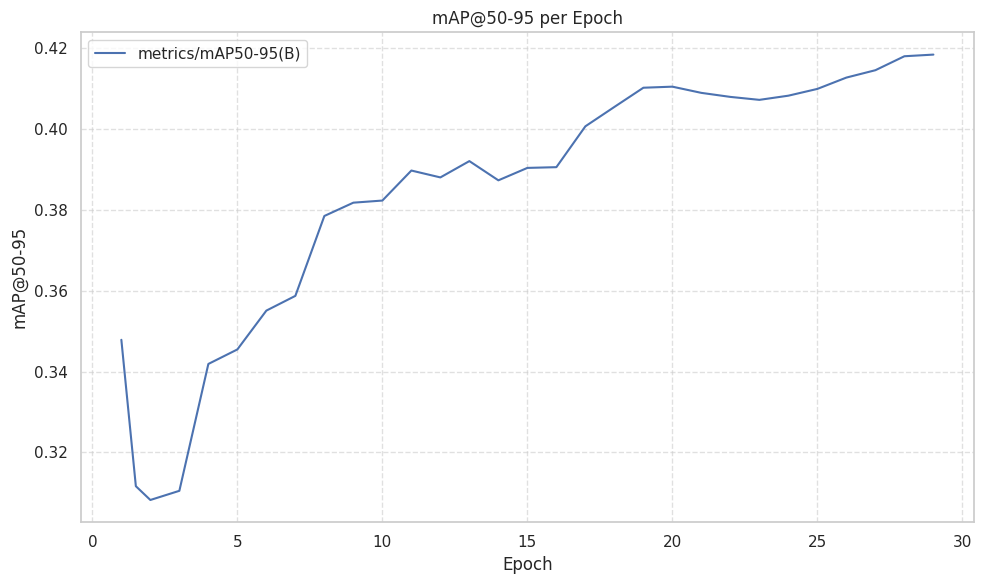

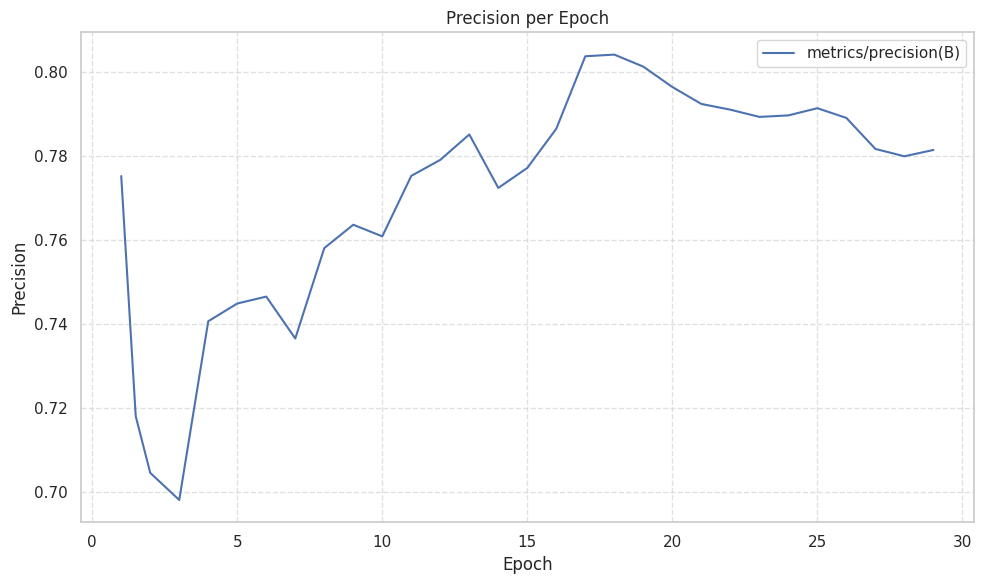

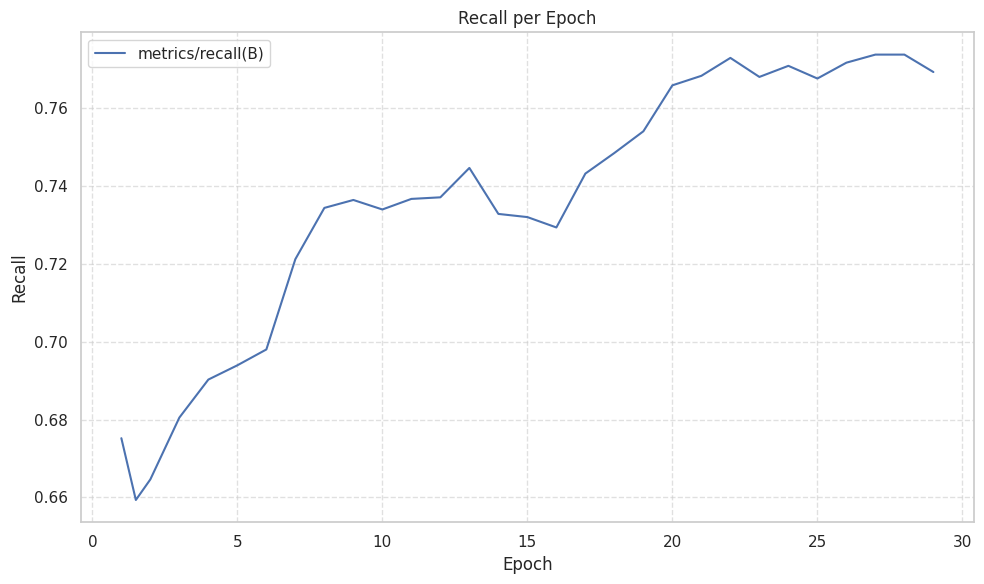

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Load results.csv
csv_path = '/content/runs/detect/yolov8_custom/results.csv'
data = pd.read_csv(csv_path)

# Apply rolling average (window size = 3) to smooth curves
smoothed = data.rolling(window=3, min_periods=1).mean()

# Define a function to plot and save metrics
def plot_metric(metric_list, ylabel, title, filename):
    plt.figure(figsize=(10, 6))
    for metric in metric_list:
        plt.plot(smoothed['epoch'], smoothed[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'/content/{filename}.png')  # 💾 Save plot
    plt.show()

# 📉 Box Loss
plot_metric(['train/box_loss', 'val/box_loss'], 'Loss', 'Box Loss', 'box_loss_plot')

# 🎯 Class Loss
plot_metric(['train/cls_loss', 'val/cls_loss'], 'Loss', 'Class Loss', 'class_loss_plot')

# 🟢 mAP@50
plot_metric(['metrics/mAP50(B)'], 'mAP@50', 'mAP@50 per Epoch', 'map50_plot')

# 🔵 mAP@50-95
plot_metric(['metrics/mAP50-95(B)'], 'mAP@50-95', 'mAP@50-95 per Epoch', 'map5095_plot')

# 🟣 Precision
plot_metric(['metrics/precision(B)'], 'Precision', 'Precision per Epoch', 'precision_plot')

# 🔶 Recall
plot_metric(['metrics/recall(B)'], 'Recall', 'Recall per Epoch', 'recall_plot')


In [26]:
from ultralytics import YOLO

model_v5 = YOLO('yolov5s.pt')
results_v5 = model_v5.train(data=yaml_path, epochs=30, imgsz=640)
metrics_v5 = model_v5.val(data=yaml_path)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 121MB/s] 


Ultralytics 8.3.108 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None,

train: Scanning /content/dataset/labels/train.cache... 1324 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1324/1324 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/labels/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.61G      1.949      2.315      1.599         42        640: 100%|██████████| 83/83 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]

                   all        331        819      0.716      0.682      0.726      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.93G      1.856       1.35      1.581         52        640: 100%|██████████| 83/83 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

                   all        331        819      0.704      0.695       0.69      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.93G      1.853      1.347      1.575         46        640: 100%|██████████| 83/83 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]


                   all        331        819      0.722      0.651      0.689       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.93G      1.836      1.315      1.584         40        640: 100%|██████████| 83/83 [00:26<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]

                   all        331        819      0.761      0.728      0.749      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.93G      1.797      1.259      1.553         56        640: 100%|██████████| 83/83 [00:25<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        331        819      0.583      0.459      0.481      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.93G      1.781      1.246      1.534         36        640: 100%|██████████| 83/83 [00:26<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


                   all        331        819      0.702      0.753      0.724      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.93G       1.77      1.216      1.523         59        640: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

                   all        331        819      0.744      0.694      0.751       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.93G      1.729      1.192      1.515         37        640: 100%|██████████| 83/83 [00:26<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]

                   all        331        819      0.715      0.697      0.738      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.93G      1.728      1.179      1.495         50        640: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


                   all        331        819      0.755      0.717      0.765      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.93G      1.708      1.162        1.5         57        640: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

                   all        331        819      0.769      0.734      0.775       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.93G      1.679      1.146      1.497         39        640: 100%|██████████| 83/83 [00:26<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]

                   all        331        819      0.736      0.681      0.743      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.93G      1.656       1.12      1.469         43        640: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]

                   all        331        819      0.772      0.753      0.795      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.93G      1.659       1.12      1.461         38        640: 100%|██████████| 83/83 [00:26<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        819      0.746      0.783      0.791      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.93G      1.663      1.108      1.474         48        640: 100%|██████████| 83/83 [00:26<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]

                   all        331        819       0.77      0.745      0.786      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.93G      1.656      1.099      1.462         49        640: 100%|██████████| 83/83 [00:26<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

                   all        331        819      0.779      0.713      0.785      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.93G      1.645      1.073       1.47         50        640: 100%|██████████| 83/83 [00:26<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        331        819      0.753      0.734      0.773      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.93G      1.614      1.055      1.445         24        640: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.00it/s]

                   all        331        819      0.774      0.748      0.784      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.93G      1.641       1.07      1.463         45        640: 100%|██████████| 83/83 [00:28<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.27it/s]

                   all        331        819      0.798        0.7      0.785       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.93G      1.605      1.077      1.445         42        640: 100%|██████████| 83/83 [00:26<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]

                   all        331        819      0.794      0.752      0.799      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.93G      1.622      1.064      1.468         41        640: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

                   all        331        819      0.771      0.733      0.781      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.93G       1.58      1.004      1.489         30        640: 100%|██████████| 83/83 [00:29<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

                   all        331        819      0.787      0.764      0.804      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.93G      1.578     0.9905      1.488         31        640: 100%|██████████| 83/83 [00:26<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        331        819      0.804      0.739      0.801      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.93G      1.569     0.9758      1.487         18        640: 100%|██████████| 83/83 [00:27<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

                   all        331        819       0.77      0.763      0.798      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.93G      1.571     0.9758      1.474         30        640: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        331        819      0.791      0.762      0.809      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.93G      1.533     0.9712      1.465         28        640: 100%|██████████| 83/83 [00:26<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

                   all        331        819      0.794      0.767      0.806      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.93G      1.548     0.9456      1.474         18        640: 100%|██████████| 83/83 [00:26<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]

                   all        331        819      0.802       0.75      0.811      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.93G      1.528     0.9599      1.469         26        640: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]

                   all        331        819      0.787      0.756      0.815      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.93G      1.504     0.9358      1.453         27        640: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]

                   all        331        819       0.77      0.757      0.796      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.93G      1.502     0.9122       1.44         20        640: 100%|██████████| 83/83 [00:26<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.00it/s]

                   all        331        819      0.782      0.754      0.808      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.93G      1.481     0.9094      1.444         26        640: 100%|██████████| 83/83 [00:25<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

                   all        331        819      0.789      0.756      0.808      0.414



30 epochs completed in 0.261 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,112,310 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


                   all        331        819      0.781      0.753      0.807      0.415
                class2        331        819      0.781      0.753      0.807      0.415
Speed: 0.4ms preprocess, 5.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.108 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,112,310 parameters, 0 gradients, 23.8 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


                   all        331        819      0.782      0.754      0.808      0.416
                class2        331        819      0.782      0.754      0.808      0.416
Speed: 1.4ms preprocess, 7.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train2


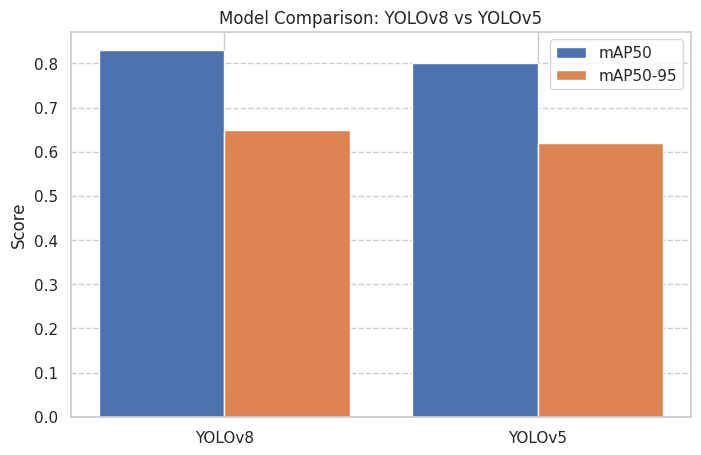

In [27]:
import matplotlib.pyplot as plt

models = ['YOLOv8', 'YOLOv5']
map50s = [0.83, 0.80]
map5095s = [0.65, 0.62]

plt.figure(figsize=(8, 5))
x = range(len(models))
plt.bar(x, map50s, width=0.4, label='mAP50', align='center')
plt.bar([p + 0.4 for p in x], map5095s, width=0.4, label='mAP50-95', align='center')
plt.xticks([p + 0.2 for p in x], models)
plt.ylabel('Score')
plt.title('Model Comparison: YOLOv8 vs YOLOv5')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()
